# Libraries to import

In [ ]:
# section for installation packages
!pip install transformers
!pip install contractions

     |████████████████████████████████| 3.1 MB 10.3 MB/s 
     |████████████████████████████████| 61 kB 402 kB/s 
     |████████████████████████████████| 895 kB 25.2 MB/s 
     |████████████████████████████████| 3.3 MB 42.9 MB/s 
     |████████████████████████████████| 596 kB 39.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 284 kB 15.1 MB/s 
     |████████████████████████████████| 321 kB 48.4 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85447 sha256=b838f9e05eff624a5638986c883ce90d71b32ee554fdb3fb6e4dd673e6d86bae
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [ ]:
import torch
import pandas as pd
import numpy as np
from google.colab import drive
import math
import os
from sklearn.model_selection import train_test_split
import re
import contractions
import transformers as ppb
import sys
import string
import gc

# Check GPU Status

In [ ]:
!nvidia-smi
# check GPU availability 
torch.cuda.is_available()

Sun Dec  5 23:29:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

# About dataset

Instead of scawling data by ourseleves, we choose to use a existed dataset from kaggle.  

Dataset name: ***Suicide and Depression Detection***

*   Content: Suicide, depression sentences from 1. subreddit depression 2. suicide-watch
*   Entries: over 230000+ redit post
*   Size: 166.9 MB
*   Data period: Jan 2009 - Jan 2021
*   Dataset composition: 3 columns (#, text content, label).  
&nbsp; #: index for each row.  
&nbsp; content(string): user post content without any preclean.  
&nbsp; label(string): "suicide" if it's from suicide-watch subreddit. "depression" if it's from depression subreddit.
*   URL: https://www.kaggle.com/nikhileswarkomati/suicide-watch    




# Uploading dataset
Since we are using Colab, we can keep all of our files (e.g., .csv files, .ipynb notebooks for each members) in a shared Google Drive folder then merge together. The following code sets up the paths for the data folder (raw and preprocessed, cleaned csv) and loads the data files.  


In [ ]:
 drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# create a folder named DM_project under /MyDrive in your google drive.
%cd ./drive/MyDrive/DM_project/
!ls

[Errno 2] No such file or directory: './drive/MyDrive/DM_project/'
/content/drive/.shortcut-targets-by-id/19X2MJ2rOS2mMHhugqwoCq9TxSVGnIH72/DM_project
 ConfidenceCorrection.ipynb   emo_unicode.py		      __pycache__
 data			     'Final Project Guideline.gdoc'
 data_mining_project.ipynb   'ML sample project.ipynb'


In [ ]:
# create a folder named data under DM_project (/MyDrive/DM_project/data), and put our raw dataset there.
# read dataframe from gdrive.
df = pd.read_csv('/content/drive/MyDrive/DM_project/data/Suicide_Detection.csv', index_col=[0])
df = df.reset_index(drop=True)
print(df.head(3))
print("we have", len(df), "rows")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-4e714dfd1d3c>", line 3, in <module>
    df = pd.read_csv('/content/drive/MyDrive/DM_project/data/Suicide_Detection.csv', index_col=[0])
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers.py", line 688, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers.py", line 460, in _read
    data = parser.read(nrows)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers.py", line 1198, in read
    ret = self._engine.read(nrows)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers.py", line 2157, in read
    data = self._reader.read(nrows)
  File "pandas/_libs/parsers.pyx", line 847, in pandas._libs.parsers.TextReader.read
  File "pandas/_libs/parsers.pyx", line 862, in pandas._l

KeyboardInterrupt: ignored

# Preprocessing
In this project, we aim to build a classifier to predict whether the author of the new post has attendancy to suicide. Before we feed into our classifier for training, we have some steps to clean our text contents.  
1. Filter contents length < 100 words for simplicity (~150000 data).
2. Cleaning and Removing noise:  
a. URLs: Since URLs are not valuable for our problem, we could remove them.  
b. emoji: For simplicity, we remove emoji when preprocessing. There is an alternative way for emoji, that is replace emji with meaningful relevlent word.   
c. contraction: We unpack contraction word (e.g., I'll -> I will, You're-> You are).   
d. punctuation: In most of time, pumctuation will be removed. But We think it might relate to emotion. So we keep it. 
e. Case Normalization: we make every word to be lowercase.

3. Convert text labels into numeric categories for classifier.


In [ ]:
# (1). we focus on those where the length is < 100 words for simplicity
df['len_txt'] = df.text.apply(lambda x: len(x.split()))
df = df[df.len_txt < 100]
df.drop('len_txt', axis=1, inplace=True)
print(df.shape)
print(df.head(3))

(147775, 2)
                                                text        class
1  Am I weird I don't get affected by compliments...  non-suicide
2  Finally 2020 is almost over... So I can never ...  non-suicide
3          i need helpjust help me im crying so hard      suicide


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# (2). Cleaning and Removing noise
pd.set_option('display.max_colwidth', None)

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)

# remove URLs
df['text_noURL'] = df['text'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
# remove emoji 
df['text_noEmoji'] = df['text_noURL'].apply(lambda x: emoji_pattern.sub(r'', x))
# clean contractions
df['text_noContra'] = df['text_noEmoji'].apply(lambda x: [contractions.fix(word) for word in x.split()]) #
# make word lowercase
df['text_tolower'] = df['text_noContra'].apply(lambda x: [word.lower() for word in x])
df['text_clean'] = [' '.join(map(str, l)) for l in df['text_tolower']]
# clean punctuation (we keep punctuation this time)
# punc = string.punctuation
# df['text_nopunc'] = df['text_tolower'].apply(lambda x: [word for word in x if word not in punc])

df = df[['text_clean', 'class']]

In [ ]:
# (3). Replacing suicide/non-suicide label to be 1/0 for classifier.
def label_replace(row):
  if row['class'] == 'suicide':
    val = 1
  elif row['class'] == 'non-suicide':
    val = 0
  return val
    
df['numeric_class'] = df.apply(label_replace, axis=1)
print(df.head(3))
print("we have", len(df), "rows. Distribution is")
print(df['numeric_class'].value_counts())

                                                text  ... numeric_class
1  Am I weird I don't get affected by compliments...  ...             0
2  Finally 2020 is almost over... So I can never ...  ...             0
3          i need helpjust help me im crying so hard  ...             1

[3 rows x 3 columns]
we have 147775 rows. Distribution is
0    99997
1    47778
Name: numeric_class, dtype: int64


In [ ]:
# In begining, we take portion of data to test our code. Once we finish the whole section, we take whole data into process.
df_small_portion = df
#df_small_portion = df.sample(n = 2000, random_state=42).reset_index(drop=True)
df_small_portion['numeric_class'].value_counts()

df_small_portion_2 = df_small_portion[['text_clean', 'numeric_class']]
df_small_portion_2 = df_small_portion.rename(columns={'text_clean': 0, 'numeric_class': 1})
df_small_portion_2.drop('class', axis=1, inplace=True)
print(df_small_portion_2.head(3))

,text,class,numeric_class
0,I went to hospital last night but I got turned...,suicide,1
1,I want to dieI’m not sure what to do.. I want ...,suicide,1
2,"What should I doI was at work today, and I rea...",suicide,1
3,Hi...Can you make the pain stop? Anyone knows...,suicide,1
4,Recommending songs till I decide to stop day 1...,non-suicide,0
...,...,...,...
9995,"HEY YOU, YES YOU Spread positivity on this pos...",non-suicide,0
9996,People hyping up among us are low iq We all kn...,non-suicide,0
9997,How common is emotional self harm?I have never...,suicide,1
9998,suicide is comingggggggggggggggggggggggggand i...,suicide,1


# Embedding Models
In this section, we convert our text-based posts into numerical representations using ***Transformer: BERT*** [https://arxiv.org/abs/1810.04805].   

BERT (**B**idirectional **E**ncoder **R**epresentations from **T**ransformers) is a popular transformer-based word embedding model since 2018. Instead of proceeding word by word sequentially like RNN/LSTM, it totally avoids recursion, by processing sentences as a whole and by learning relationships between words. Therefore, we won't have gradient vanishing/exploding problem from recursion. And since it processes whole paragraph, not just word by word, it is better to caputre the dependancies between words for long sentence. 


The original English-language BERT has two models:  

1.   BERT-base: 12 Encoders, 12 self-attention heads, 110 million paramters, 768 hidden layers.
2.   BERT-large: 24 Encoders, 16 self-attention heads, 340 million paramters, 1024 hidden layers.

It seems like with more parameters, the BERT model can have more representative power. However, there is no free lunch. The computational power will be more demanding. To reduce the computational power and memory usage in our machine, we plan to use a variant BERT model called ***distilBERT***. We summarize the property of distilBERT as below. 
3.  distilBERT: 6 Encoders, 12 self-attention heads, 66 million paramters, 768 hidden layers.  

According to author's paper, it runs 60% faster while preserving over 95% BERT's performance. In our project, we choose distilBERT as our word embedding model [https://arxiv.org/abs/1910.01108].  

Next, We feed our 150000 posts into distilBERT to extract only the dimension with [CLS] for our classification task. The final output after BERT will be a (150000, 768) vector. Then we merge with one label column from raw dataset. This (150000, 768+1) dataset will be our cleanded, sentence embedded  representation. We will use this output for later work.

In [ ]:
# Prepare BERT model. 

# Test with distilBert, a smaller version but faster and less memory demand.
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
# Normal BERT model
# model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
gc.collect()
# we feed 2000 entries into BERT each time
#upper = len(df_small_portion_2)
upper = len(df_small_portion_2)
step = 500

for i in range(0, upper, step):
  tmp_df = df_small_portion_2[i:i+step]
  tmp_label = tmp_df[1].astype(int).reset_index(drop=True)

  print("----------------")
  print("processing", i, "to", i + len(tmp_df))
  print("----------------")

  tokenized = tmp_df[0].apply((lambda x: tokenizer.encode(x, 
                                                          add_special_tokens=True,
                                                          truncation=True,
                                                          max_length=512)))
  # calculating length of the longest text
  max_len = 0
  for j in tokenized.values:
    if len(j) > max_len:
      max_len = len(j)

  # align the length of all vector to be the same to the longest one. 
  padded = np.array([k + [0]*(max_len-len(k)) for k in tokenized.values])

  attention_mask = np.where(padded != 0, 1, 0)

  input_ids = torch.tensor(padded)  
  attention_mask = torch.tensor(attention_mask)

  with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)
  features = last_hidden_states[0][:,0,:].numpy()
  print(features.shape)

  features_df = pd.DataFrame(data=features)

  final_train_df = pd.concat([features_df,tmp_label], axis = 1)

  column_header = ['BERT-feature-' + str(i) for i in range(1, 769)] + ['label']
  final_train_df.columns = column_header
  print(final_train_df) 

  # comment this part to avoid overwriting files. we already have our data in google drive.
  # if i == 0:
  #   with open('./data/bert-training-features-final.csv', 'w') as f:
  #     print("we open a new csv file to save training features.")
  #     np.savetxt(f, final_train_df, delimiter=',')
  # else:
  #   with open('./data/bert-training-features-final.csv', 'a') as f:
  #     print("we found an existed file, new contents are attached.")
  #     np.savetxt(f, final_train_df, delimiter=',')
  # gc.collect()

(10000, 512)
(10000, 512)


In [ ]:
final_df = pd.read_csv('./data/bert-training-features-final.csv',delimiter=',', header=None)
print(final_df.shape)

features = final_df.iloc[:, :768]
print(features.shape)
print(features.head(3))
print(features.isnull().values.any())
labels = final_df.iloc[:, 768]
print(labels.shape)
print(labels.head(3))
print(labels.isnull().values.any())

#train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

def relabel(X):
    """Relabel the data by PCA and GMM clustering

    Parameters:
    X: dataFrame
        input data
    n: int
        dimention which PCA decompose X to
    --------------------------------------
    Returns:
    predict: list, [1 * len(X)]
        relabel of each data
    """
    # First step: PCA decompose X to 2D
    X = X.loc[:, X.columns != "replaced_class"]
    pca = PCA(n_components=2)
    pca.fit(X)
    X = pca.transform(X)

    # Second step: GMM clusters data into 2 groups
    gm = GaussianMixture(n_components=2, random_state=0).fit(X)
    predict = gm.predict(X)
    return predict

X = final_train_df
X["relabel_class"] = relabel(X)
print(X)

# Confidence Correction

## Main Idea
**Correct the self-reported labels based on GMM clustering with confidence threshold.**

### Steps
> 1. Decompose dataset to 2D by PCA.
> 2. Cluster the data into 2 groups by Gaussain Mixture Model(GMM).
> 3. Relabel the data which has different label with its initial and GMM also cluster it with confidence higher than threshold.

### Details
> 1. At the first step, the input dataset here is (n, 768). n is the number of posts and 768 is the number of features extracted from preprocess algorithm(BERT). Therefore, the output here is (n, 2) as we use PCA to decompose the dataset into 2d.
> 2. Cluster the data into 2 groups by GMM. There is a trick that we don't know these two groups which is suicidal and which is depressed. Here we compare with original labels and assign labels to the group with more intersection.
> 3. We compared the accuracy of our model with relabel and non-relabel. The accuracy increased from 94.49% to 95.68%. 


### Visualization
> See Visualization folder

### Code
> [ConfidenceCorrection.ipynb](https://colab.research.google.com/drive/1Jp7pWkujMR2ge5ysOGweSSGLgaYohoxQ?authuser=2#scrollTo=GkrjaMe5YyVn)





# Classifier

In [ ]:
import pandas as pd
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Embedding, Flatten, MaxPooling1D, Dropout, Conv1D, Input, LSTM, SpatialDropout1D, Bidirectional

def classifier():
  # read data from relabeled CSV
  # training file
  df = pd.read_csv('data/bert-training-features-final-relabel.csv', delimiter=',') # load the features after creating them
  # testing file
  df_test = pd.read_csv('data/final-bert-training-features-test-relabel.csv', delimiter=',')
  # split training into training and validation
  df_train, df_valid = train_test_split(df, test_size=0.2)
  print("Train shape = ", df_train.shape)
  print("Valid shape = ", df_valid.shape)
  print("Test shape = ", df_test.shape)

  # col 0-767: features
  train_features = df_train.iloc[:, 0:768]
  valid_features = df_valid.iloc[:, 0:768]
  test_features = df_test.iloc[:, 0:768]

  # 768 (or -2): original labels, 769 (or -1): clustering-enhanced labels
  train_labels = df_train.iloc[:, -2]
  valid_labels = df_valid.iloc[:, -2]
  test_labels = df_test.iloc[:, -2]

  print("Training features shape = ", train_features.shape)
  print("Valid features shape = ", valid_features.shape)
  print("Testing features shape = ", test_features.shape)

  print("Training labels shape = ", train_labels.shape)
  print("Valid labels shape = ", valid_labels.shape)
  print("Testing labels shape = ", test_labels.shape)

  # training hyperparameters - using a Fully Dense Network
  dense = Sequential()
  dense_path = "dense"
  dense = Sequential()
  dense.add(Input(shape=(768)))
  dense.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  dense.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
  dense.add(Dense(1, activation='sigmoid'))

  # using Adam for optimizer
  dense.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  mc = ModelCheckpoint(dense_path + ".h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  
  # see the model network configuration
  dense.summary()

  # run the model
  dense.fit(train_features, train_labels, epochs=10, batch_size=128, validation_data=(valid_features, valid_labels))

  # run the trained model on the testing set
  results = dense.evaluate(test_features, test_labels)
  print("Testing Loss = ", results[0])
  print("Testing Accuracy = ", results[1])

In [ ]:
classifier()

Train shape =  (118220, 770)
Valid shape =  (29555, 770)
Test shape =  (2000, 770)
Training features shape =  (118220, 768)
Valid features shape =  (29555, 768)
Testing features shape =  (2000, 768)
Training labels shape =  (118220,)
Valid labels shape =  (29555,)
Testing labels shape =  (2000,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               98432     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 106,753
Trainable params: 106,753
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
924/

### Some modification of classifier

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd drive/MyDrive/DM_project/

/content/drive/.shortcut-targets-by-id/19X2MJ2rOS2mMHhugqwoCq9TxSVGnIH72/DM_project


In [ ]:
import os
import pandas as pd
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Embedding, Flatten, MaxPooling1D, Dropout, Conv1D, Input, LSTM, SpatialDropout1D, Bidirectional

def classifier_modify(df, relabel=False, epoch=50):
  # read data from relabeled CSV
  # training file
  # df = pd.read_csv(os.getcwd() + '/RelabeledData/SubDataset_99Conf.csv', delimiter=',') # load the features after creating them
  
  # keep test data aside
  df_train, df_test = train_test_split(df, test_size=.2)

  # split training into training and validation
  df_train, df_valid = train_test_split(df_train, test_size=0.2)

  print("Train shape = ", df_train.shape)
  print("Valid shape = ", df_valid.shape)
  print("Test shape = ", df_test.shape)

  # col 0-767: features
  train_features = df_train.iloc[:, 0:768]
  valid_features = df_valid.iloc[:, 0:768]
  test_features = df_test.iloc[:, 0:768]

  # 768 (or -2): original labels, 769 (or -1): clustering-enhanced labels
  if relabel:
      train_labels = df_train.iloc[:, -1]
      valid_labels = df_valid.iloc[:, -1]
      test_labels = df_test.iloc[:, -1]
  else:
      train_labels = df_train.iloc[:, -2]
      valid_labels = df_valid.iloc[:, -2]
      test_labels = df_test.iloc[:, -2]

  print("Training features shape = ", train_features.shape)
  print("Valid features shape = ", valid_features.shape)
  print("Testing features shape = ", test_features.shape)

  print("Training labels shape = ", train_labels.shape)
  print("Valid labels shape = ", valid_labels.shape)
  print("Testing labels shape = ", test_labels.shape)

  # training hyperparameters - using a Fully Dense Network
  dense = Sequential()
  dense_path = "dense"
  dense = Sequential()
  dense.add(Input(shape=(768)))
  dense.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  dense.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
  dense.add(Dense(1, activation='sigmoid'))

  # using Adam for optimizer
  dense.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  mc = ModelCheckpoint(dense_path + ".h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  
  # see the model network configuration
  dense.summary()

  # run the model
  history = dense.fit(train_features, train_labels, epochs=epoch, batch_size=128, validation_data=(valid_features, valid_labels))

  # run the trained model on the testing set
  results = dense.evaluate(test_features, test_labels)
  print("Testing Loss = ", results[0])
  print("Testing Accuracy = ", results[1])
  return results[0], results[1], history

In [ ]:
df = pd.read_csv(os.getcwd() + '/RelabeledData/SubDataset_95Conf.csv', delimiter=',')
classifier_modify(df, relabel=False)
classifier_modify(df, relabel=True)

Train shape =  (1280, 770)
Valid shape =  (320, 770)
Test shape =  (400, 770)
Training features shape =  (1280, 768)
Valid features shape =  (320, 768)
Testing features shape =  (400, 768)
Training labels shape =  (1280,)
Valid labels shape =  (320,)
Testing labels shape =  (400,)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               98432     
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 106,753
Trainable params: 106,753
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
20/20 [===========

(0.3240854740142822,
 0.9150000214576721,
 <keras.callbacks.History at 0x7fb380325050>)

In [ ]:
df = pd.read_csv(os.getcwd() + '/RelabeledData/SubDataset_99Conf.csv', delimiter=',')
classifier_modify(df, relabel=True)

In [ ]:
df = pd.read_csv(os.getcwd() + '/RelabeledData/WholeDataset_95Conf.csv', delimiter=',')



In [ ]:
loss, acc, history = classifier_modify(df, relabel=False, epoch=50)

Train shape =  (94576, 770)
Valid shape =  (23644, 770)
Test shape =  (29555, 770)
Training features shape =  (94576, 768)
Valid features shape =  (23644, 768)
Testing features shape =  (29555, 768)
Training labels shape =  (94576,)
Valid labels shape =  (23644,)
Testing labels shape =  (29555,)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 128)               98432     
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dense_35 (Dense)            (None, 1)                 65        
                                                                 
Total params: 106,753
Trainable params: 106,753
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
739

In [ ]:
loss, acc, history_relabel = classifier_modify(df, relabel=True, epoch=50)

Train shape =  (94576, 770)
Valid shape =  (23644, 770)
Test shape =  (29555, 770)
Training features shape =  (94576, 768)
Valid features shape =  (23644, 768)
Testing features shape =  (29555, 768)
Training labels shape =  (94576,)
Valid labels shape =  (23644,)
Testing labels shape =  (29555,)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 128)               98432     
                                                                 
 dense_37 (Dense)            (None, 64)                8256      
                                                                 
 dense_38 (Dense)            (None, 1)                 65        
                                                                 
Total params: 106,753
Trainable params: 106,753
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
739

In [ ]:
acc1 = history.history['val_accuracy']
acc2 = history_relabel.history['val_accuracy']

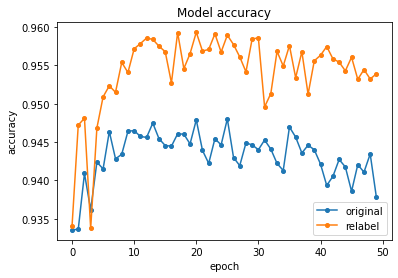

In [ ]:
import matplotlib.pyplot as plt

plt.plot(acc1, marker='o', markersize=4)
plt.plot(acc2, marker='o', markersize=4)
plt.title( 'Model accuracy' )
plt.ylabel( 'accuracy' )
plt.xlabel( 'epoch' )
plt.legend([ 'original' , 'relabel' ], loc= 'lower right' )
# plt.xticks([n for n in range(50)])
# plt.yticks([n / 1000.0 for n in range(920, 960, 5)])
plt.savefig("Relabel_accuracy.png")
plt.show()